# HW9 - Feature Engineering (FE) & EDA Assignment
* __Zhenyu Wang__
* __UNI: zw2847__

# Table of Contents
- [Section 1: EDA & Data Preparation](#section-1)
- [Section 2: H2O Initialize](#section-2)
- [Section 3: Modeling - GBM (Gradient Boosting Machine) Model](#section-3)
- [Section 4: Modeling - Deep Learning Model](#section-4)
- [Section 5: Model Summary & Conclusion](#section-5)

## Section 1: EDA <a class="anchor" id="section-1"></a>

> Import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

> Load the dataset

In [2]:
df = pd.read_csv("XYZloan_default_selected_vars.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,0,1,1,1,31,2,1,12,2017/7/6 10:21,ios,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,1,2,2,0,27,1,1,12,2017/4/6 12:51,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB
2,2,3,3,0,33,1,4,12,2017/7/1 14:11,h5,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB
3,3,4,4,0,34,2,4,12,2017/7/7 10:10,android,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,OPPO
4,4,5,5,0,47,2,1,12,2017/7/6 14:37,h5,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB


> Summary statistics for the dataset

In [3]:
print(df.shape)

(80000, 89)


In [4]:
print(df.describe())

       Unnamed: 0.1    Unnamed: 0            id  loan_default         AP001  \
count  80000.000000  80000.000000  80000.000000  80000.000000  80000.000000   
mean   39999.500000  40000.500000  40000.500000      0.193600     31.706913   
std    23094.155105  23094.155105  23094.155105      0.395121      7.075070   
min        0.000000      1.000000      1.000000      0.000000     20.000000   
25%    19999.750000  20000.750000  20000.750000      0.000000     27.000000   
50%    39999.500000  40000.500000  40000.500000      0.000000     30.000000   
75%    59999.250000  60000.250000  60000.250000      0.000000     35.000000   
max    79999.000000  80000.000000  80000.000000      1.000000     56.000000   

              AP002         AP003         AP004        AP007         AP008  \
count  80000.000000  80000.000000  80000.000000  80000.00000  80000.000000   
mean       1.321813      2.014925     11.235413      3.30130      3.117200   
std        0.467174      1.196806      2.212313      1

In [5]:
# Check for missing values
print(df.isnull().sum())

Unnamed: 0.1       0
Unnamed: 0         0
id                 0
loan_default       0
AP001              0
                ... 
CD170            381
CD172            381
CD173            381
MB005           2793
MB007              0
Length: 89, dtype: int64


> Data Split

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
     df, test_size=0.40, random_state=42)

In [7]:
train.shape

(48000, 89)

> Distribution of the target variable `loan_default`

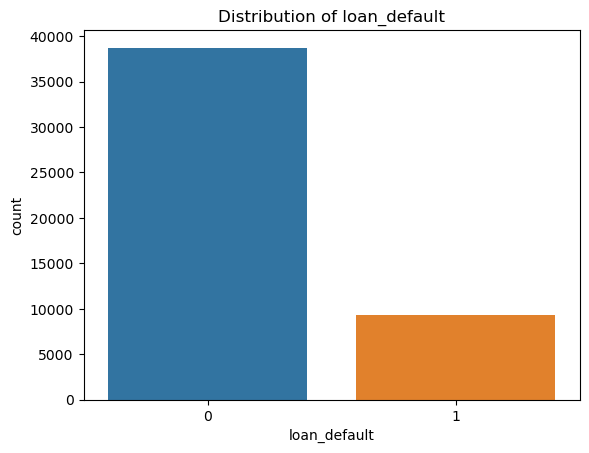

In [8]:
sns.countplot(x='loan_default', data=train)
plt.title('Distribution of loan_default')
plt.show()

In [9]:
var = pd.DataFrame(train.dtypes).reset_index()
var.columns = ['varname','dtype']
var['source'] = var['varname'].str[:2]
var.head()

,varname,dtype,source
0,Unnamed: 0.1,int64,Un
1,Unnamed: 0,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP


In [10]:
var['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
Un     2
MB     2
id     1
lo     1
Name: source, dtype: int64

In [11]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [12]:
train['loan_default'].value_counts(dropna=False)

0    38736
1     9264
Name: loan_default, dtype: int64

## Section 2: H2O Initialize <a class="anchor" id="section-2"></a>

In [13]:
#pip install h2o

In [14]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.18" 2023-01-17 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.18+9-LTS-195); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.18+9-LTS-195, mixed mode)
  Starting server from /Users/jimac/opt/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/nj/2lz1zcjx46qc0b0_x0vsc8jc0000gn/T/tmp5pc6nqiy
  JVM stdout: /var/folders/nj/2lz1zcjx46qc0b0_x0vsc8jc0000gn/T/tmp5pc6nqiy/h2o_jimac_started_from_python.out
  JVM stderr: /var/folders/nj/2lz1zcjx46qc0b0_x0vsc8jc0000gn/T/tmp5pc6nqiy/h2o_jimac_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_jimac_2mwu0q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [15]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

## Section 3: Modeling - GBM <a class="anchor" id="section-3"></a>

In [16]:
target='loan_default'

> First, we only take 10% of our data to testing our model, if it's work well, we will continue using this model to train for all the data.

In [17]:
train_smpl = train.sample(frac=0.1, random_state=123)
test_smpl = test.sample(frac=0.1, random_state=123)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [18]:
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

In [19]:
gbm_v1 = H2OGradientBoostingEstimator(
        model_id = 'gbm_v1',
        seed=1234)
gbm_v1.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |

/Users/jimac/opt/anaconda3/lib/python3.9/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [TD051, TD062, TD061, CR012, TD048, AP005, TD044, TD055]
  warnings.warn(mesg["message"], RuntimeWarning)
/Users/jimac/opt/anaconda3/lib/python3.9/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: gbm_v1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          19761                  5            5            5             14            31            24.14

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.10990009771764472
RMSE: 0.33151183646688204
MAE: 0.2486302488723565
RMSLE: 0.22979829069578012
Mean Residual Deviance: 0.10990009771764472

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-11-25 23:26:57  0.126 sec   0.0                0.3918062140586832   0.3070242187500015   0.1535121093749987
     2023-11-25 23:26:57  0.279 sec   1.0                0.38860235247943015  0.30439230244296295  0.15101178835254725
     2023-11-25 23:26:57  0.327 sec   2.0                0.3860463388028379   0.30218881607055664  0.14903177570307552
     2023-11-25 23:26:57  0.371 sec   3.0                0.3833429479053047   0.29981913407643634  0.14695181570872917
     2023-11-25 23:26:57  0.421 sec   4.0                0.38107434453536915  0.2977077576921632   0.14521765606306122
     2023-11-25 23:26:57  0.457 sec   5.0                0.37889692609688247  0.2956274135690182   0.1435628806056664
     2023-11-25 23:26:57  0.499 sec   6.0                0.37656384414386757  0.2934700891096145   0.14180032871640696
     2023-11-25 23:26:58  0.540 sec   7.0                0.37461157443426835  0.29160617229683944  0.14033383170012137
     2023-11-25 23:26:58  0.564 sec   8.0                0.37280919866233797  0.2898664252506569   0.13898669860725457
     2023-11-25 23:26:58  0.586 sec   9.0                0.37084560834854347  0.2879534689321493   0.13752646523140127
---  ---                  ---         ---                ---                  ---                  ---
     2023-11-25 23:26:58  1.207 sec   41.0               0.33780652453788207  0.25473953303206753  0.11411324802036271
     2023-11-25 23:26:58  1.226 sec   42.0               0.3372475593366802   0.25418087618655894  0.11373591627854765
     2023-11-25 23:26:58  1.244 sec   43.0               0.3368209326697422   0.2537271009517038   0.11344834068451502
     2023-11-25 23:26:58  1.260 sec   44.0               0.33594134600881576  0.25289962643163905  0.11285658795821488
     2023-11-25 23:26:58  1.277 sec   45.0               0.33503877812481364  0.2520725682821285   0.11225098284736812
     2023-11-25 23:26:58  1.295 sec   46.0               0.33445971728435986  0.25149344020304853  0.11186330248593393
     2023-11-25 23:26:58  1.311 sec   47.0               0.33387862332246826  0.2508325717335417   0.11147493511170666
     2023-11-25 23:26:58  1.328 sec   48.0               0.3334167391975466   0.25041109141951895  0.11116672197712482
     2023-11-25 23:26:58  1.348 sec   49.0               0.3321421594872048   0.24923455861967037  0.11031841410882381
     2023-11-25 23:26:58  1.365 sec   50.0               0.33151183646688204  0.2486302488723565   0.10990009771764472
[51 rows x 7 columns]


Variable Importances: 
variable    relative_importance    scaled_importance     percentage
----------  ---------------------  --------------------  ---------------------
MB007       222.4158172607422      1.0                   0.21235401094210268
TD013       71.24734497070312      0.32033398455280965   0.06802420646085469
MB005       66.0350341796875       0.29689900202679115   0.06304769392509657
AP003       55.86554718017578      0.25117614326270493

> Create a function to visulize variable importance

In [20]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()

> Top 10 `variable_importances`

In [21]:
variable_importances = gbm_v1._model_json['output']['variable_importances']['variable'][:10]
scaled_importances = gbm_v1._model_json['output']['variable_importances']['scaled_importance'][:10]

# Print the top 10 variable importances along with their scaled importances
for i, (importance, scaled_importance) in enumerate(zip(variable_importances, scaled_importances), start=1):
    print(f"Rank {i}: Variable Importance: {importance}, Scaled Importance: {scaled_importance:.3f}")

Rank 1: Variable Importance: MB007, Scaled Importance: 1.000
Rank 2: Variable Importance: TD013, Scaled Importance: 0.320
Rank 3: Variable Importance: MB005, Scaled Importance: 0.297
Rank 4: Variable Importance: AP003, Scaled Importance: 0.251
Rank 5: Variable Importance: CR009, Scaled Importance: 0.240
Rank 6: Variable Importance: TD005, Scaled Importance: 0.190
Rank 7: Variable Importance: CR015, Scaled Importance: 0.169
Rank 8: Variable Importance: TD022, Scaled Importance: 0.163
Rank 9: Variable Importance: AP008, Scaled Importance: 0.155
Rank 10: Variable Importance: TD023, Scaled Importance: 0.153


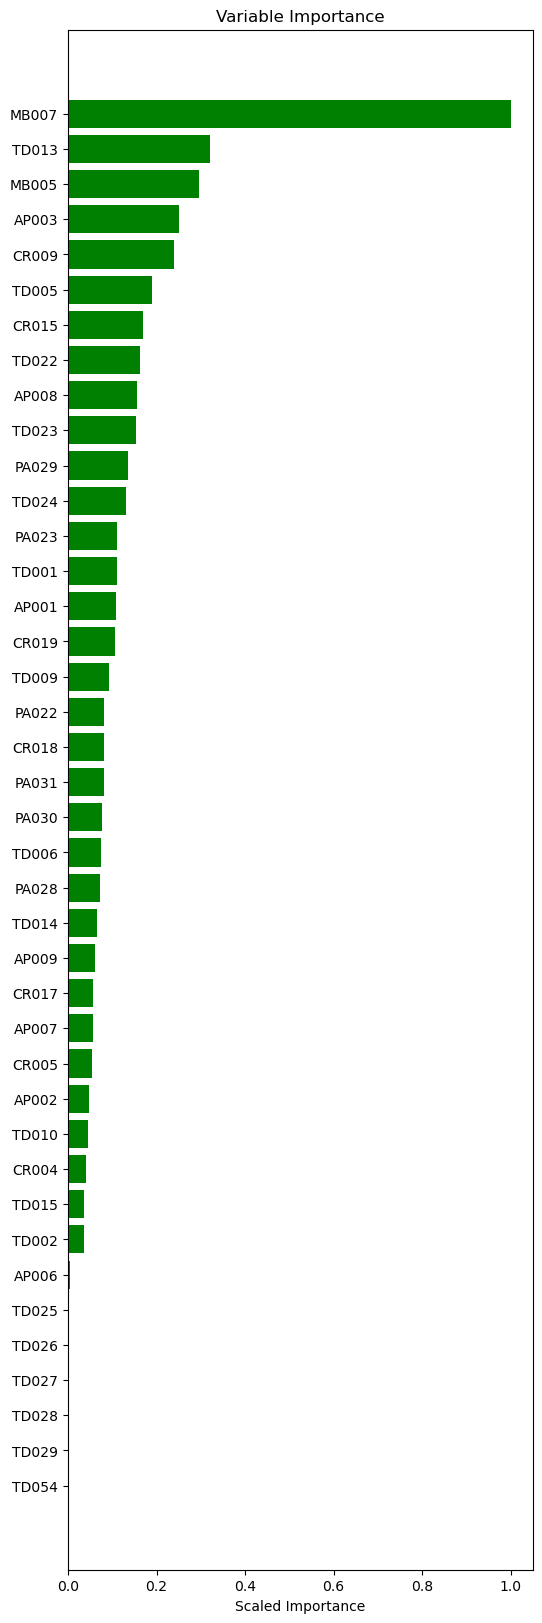

In [22]:
VarImp(gbm_v1)

In [23]:
predictions = gbm_v1.predict(test_hex)
predictions.head()
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/jimac/opt/anaconda3/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["4G", "ALPS", "CMDC", "IPHONE3", "QIKU"]
  warnings.warn(w)


,loan_default,predict
0,0,0.300770
1,0,0.125067
2,0,0.181889
3,0,0.391399
4,0,0.080911


> Define a `createGains` Function, for repetition purpose of generate the gain table 

In [24]:
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

In [25]:
createGains(gbm_v1)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/jimac/opt/anaconda3/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["4G", "ALPS", "CMDC", "IPHONE3", "QIKU"]
  warnings.warn(w)


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,107,213,320,107,213,0.17,0.08,61.8,1.73,9.0,33.44
1,320,77,243,640,184,456,0.30,0.18,123.6,1.49,12.0,28.75
2,320,69,251,960,253,707,0.41,0.27,185.4,1.36,14.0,26.35
3,320,71,249,1280,324,956,0.52,0.37,247.2,1.31,15.0,25.31
4,320,67,253,1600,391,1209,0.63,0.47,309.0,1.27,16.0,24.44
5,320,51,269,1920,442,1478,0.72,0.57,370.8,1.19,15.0,23.02
6,320,57,263,2240,499,1741,0.81,0.67,432.6,1.15,14.0,22.28
7,320,49,271,2560,548,2012,0.89,0.78,494.4,1.11,11.0,21.41
8,320,39,281,2880,587,2293,0.95,0.89,556.2,1.06,6.0,20.38


> Define the `ROC_AUC` Function to plot the Roc Curve

In [26]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('   * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

   * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



/Users/jimac/opt/anaconda3/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["4G", "ALPS", "CMDC", "IPHONE3", "QIKU"]
  warnings.warn(w)


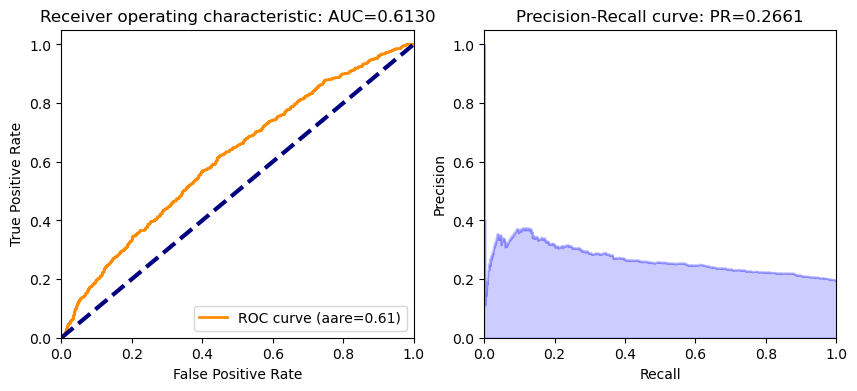

In [27]:
ROC_AUC(gbm_v1,test_hex,'loan_default')

> - Entire Data <a class="anchor" id="section-3-2"></a>

In [28]:
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [29]:
gbm_v2 = H2OGradientBoostingEstimator(
        model_id = 'gbm_v2',
        ntrees = 500,
        nfolds=10,
        min_rows=100,
        seed=1234)
gbm_v2.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |

/Users/jimac/opt/anaconda3/lib/python3.9/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [CR012, AP005]
  warnings.warn(mesg["message"], RuntimeWarning)
/Users/jimac/opt/anaconda3/lib/python3.9/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: gbm_v2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    259                259                         89788                  0            5            4.98069       1             32            18.749

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.1321592207510672
RMSE: 0.3635370968017806
MAE: 0.2760800013461749
RMSLE: 0.2540712464787914
Mean Residual Deviance: 0.1321592207510672

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.1490743318703394
RMSE: 0.386101452820809
MAE: 0.29353612554168373
RMSLE: 0.2714808173240756
Mean Residual Deviance: 0.1490743318703394

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.293532   0.00391924  0.29097       0.290847      0.296239      0.298926      0.295117      0.286173      0.290797      0.298242      0.2948        0.29321
mean_residual_deviance  0.149072   0.00418258  0.146348      0.14533       0.151179      0.154367      0.152281      0.141915      0.14509       0.153698      0.151247      0.149259
mse                     0.149072   0.00418258  0.146348      0.14533       0.151179      0.154367      0.152281      0.141915      0.14509       0.153698      0.151247      0.149259
r2                      0.0426583  0.00665074  0.0508523     0.0425606     0.052027      0.0433441     0.0375033     0.0516891     0.0377707     0.0344695     0.0368477     0.0395184
residual_deviance       0.149072   0.00418258  0.146348      0.14533       0.151179      0.154367      0.152281      0.141915      0.14509       0.153698      0.151247      0.149259
rmse                    0.386064   0.0054291   0.382555      0.381222      0.388818      0.392896      0.390232      0.376716      0.380907      0.392044      0.388905      0.38634
rmsle                   0.271464   0.00308767  0.269252      0.268949      0.272452      0.275229      0.273731      0.265707      0.269253      0.275095      0.273193      0.271775

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  -------------------
     2023-11-25 23:28:19  1 min 11.879 sec  0.0                0.39465301215116366  0.3115019999999918   0.15575099999998654
     2023-11-25 23:28:20  1 min 11.916 sec  1.0                0.39295126958576     0.31009115773191054  0.15441070026906062
     2023-11-25 23:28:20  1 min 11.948 sec  2.0                0.39151218782572855  0.3088005507135143   0.15328179321608854
     2023-11-25 23:28:20  1 min 11.975 sec  3.0                0.3903182886722837   0.30763935853447766  0.15234836647206018
     2023-11-25 23:28:20  1 min 12.002 sec  4.0                0.38920371063582826  0.3065290829939768   0.15147952837269754
     2023-11-25 23:28:20  1 min 12.032 sec  5.0                0.3882424116733356   0.3054915150438125   0.1507321702219278
     2023-11-25 23:28:20  1 min 12.060 sec  6.0                0.38734565638711776  0.3045127997584641   0.1500366575219671
     2023-11-25 23:28:20  1 min 12.089 sec  7.0                0.3866006705116712   0.30363363717341174  0.14946007844007375
     2023-11-25 23:28:20  1 min 12.117 sec  8.0            

> Top 10 `variable_importances`

In [30]:
variable_importances = gbm_v2._model_json['output']['variable_importances']['variable'][:10]
scaled_importances = gbm_v2._model_json['output']['variable_importances']['scaled_importance'][:10]

# Print the top 10 variable importances along with their scaled importances
for i, (importance, scaled_importance) in enumerate(zip(variable_importances, scaled_importances), start=1):
    print(f"Rank {i}: Variable Importance: {importance}, Scaled Importance: {scaled_importance:.3f}")

Rank 1: Variable Importance: MB007, Scaled Importance: 1.000
Rank 2: Variable Importance: TD013, Scaled Importance: 0.531
Rank 3: Variable Importance: AP003, Scaled Importance: 0.409
Rank 4: Variable Importance: TD009, Scaled Importance: 0.240
Rank 5: Variable Importance: CR015, Scaled Importance: 0.207
Rank 6: Variable Importance: MB005, Scaled Importance: 0.198
Rank 7: Variable Importance: TD005, Scaled Importance: 0.173
Rank 8: Variable Importance: AP001, Scaled Importance: 0.135
Rank 9: Variable Importance: TD014, Scaled Importance: 0.118
Rank 10: Variable Importance: CR009, Scaled Importance: 0.109


In [31]:
createGains(gbm_v2)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/jimac/opt/anaconda3/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["AND", "ANDROID", "APPLE", "EYU", "HASEE", "HONGLAJIAO", "IPAD3", "KDDI", "KINGSUN", "MANN", ...1 not listed..., "MLLED", "MONEYMAKINGMACHINE", "OUKI", "PHILIPS", "PROTRULY", "RAMOS", "REDGOO", "SM-W2016", "VOLTE", "YEPEN"]
  warnings.warn(w)


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1148,2052,3200,1148,2052,0.18,0.08,622.4,1.84,10.0,35.88
1,3200,907,2293,6400,2055,4345,0.33,0.17,1244.8,1.65,16.0,32.11
2,3200,850,2350,9600,2905,6695,0.47,0.26,1867.2,1.56,21.0,30.26
3,3200,723,2477,12800,3628,9172,0.58,0.36,2489.6,1.46,22.0,28.34
4,3200,613,2587,16000,4241,11759,0.68,0.46,3112.0,1.36,22.0,26.51
5,3200,531,2669,19200,4772,14428,0.77,0.56,3734.4,1.28,21.0,24.85
6,3200,502,2698,22400,5274,17126,0.85,0.66,4356.8,1.21,19.0,23.54
7,3200,409,2791,25600,5683,19917,0.91,0.77,4979.2,1.14,14.0,22.20
8,3200,311,2889,28800,5994,22806,0.96,0.88,5601.6,1.07,8.0,20.81


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

   * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



/Users/jimac/opt/anaconda3/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["AND", "ANDROID", "APPLE", "EYU", "HASEE", "HONGLAJIAO", "IPAD3", "KDDI", "KINGSUN", "MANN", ...1 not listed..., "MLLED", "MONEYMAKINGMACHINE", "OUKI", "PHILIPS", "PROTRULY", "RAMOS", "REDGOO", "SM-W2016", "VOLTE", "YEPEN"]
  warnings.warn(w)


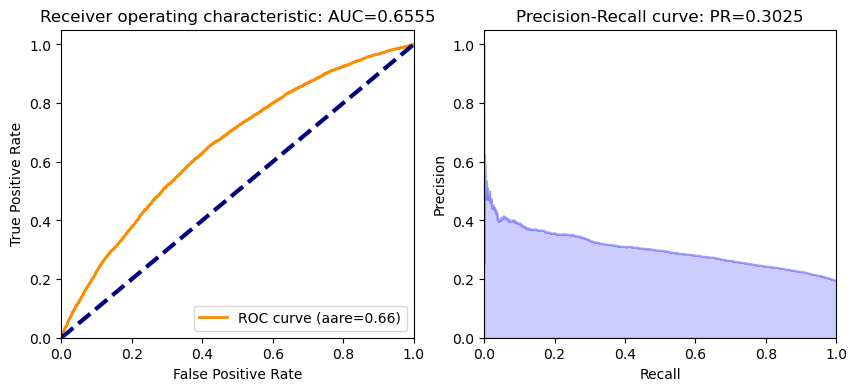

In [32]:
ROC_AUC(gbm_v2,test_hex,'loan_default')

> - Find the best Hyperparameter using grid search and Drop Useless Variable <a class="anchor" id="section-3-5"></a>

> Top 50 `variable_importances` from gbm_v2

In [33]:
variable_importances = gbm_v2._model_json['output']['variable_importances']['variable'][:50]
scaled_importances = gbm_v2._model_json['output']['variable_importances']['scaled_importance'][:50]

# Print the top 10 variable importances along with their scaled importances
for i, (importance, scaled_importance) in enumerate(zip(variable_importances, scaled_importances), start=1):
    print(f"Rank {i}: Variable Importance: {importance}, Scaled Importance: {scaled_importance:.3f}")

Rank 1: Variable Importance: MB007, Scaled Importance: 1.000
Rank 2: Variable Importance: TD013, Scaled Importance: 0.531
Rank 3: Variable Importance: AP003, Scaled Importance: 0.409
Rank 4: Variable Importance: TD009, Scaled Importance: 0.240
Rank 5: Variable Importance: CR015, Scaled Importance: 0.207
Rank 6: Variable Importance: MB005, Scaled Importance: 0.198
Rank 7: Variable Importance: TD005, Scaled Importance: 0.173
Rank 8: Variable Importance: AP001, Scaled Importance: 0.135
Rank 9: Variable Importance: TD014, Scaled Importance: 0.118
Rank 10: Variable Importance: CR009, Scaled Importance: 0.109
Rank 11: Variable Importance: TD024, Scaled Importance: 0.105
Rank 12: Variable Importance: TD001, Scaled Importance: 0.100
Rank 13: Variable Importance: AP007, Scaled Importance: 0.094
Rank 14: Variable Importance: PA028, Scaled Importance: 0.087
Rank 15: Variable Importance: CR019, Scaled Importance: 0.082
Rank 16: Variable Importance: AP008, Scaled Importance: 0.080
Rank 17: Variable

> Drop Scaled Importance greater than 5% in gbm_v2 model , we will only use top 30 importance variables to build our final model

In [34]:
selected_features = list(gbm_v2._model_json['output']['variable_importances']['variable'][:30])
selected_features

['MB007',
 'TD013',
 'AP003',
 'TD009',
 'CR015',
 'MB005',
 'TD005',
 'AP001',
 'TD014',
 'CR009',
 'TD024',
 'TD001',
 'AP007',
 'PA028',
 'CR019',
 'AP008',
 'TD010',
 'PA023',
 'PA029',
 'CR004',
 'TD023',
 'AP002',
 'CR018',
 'PA031',
 'TD006',
 'TD022',
 'CR017',
 'CR005',
 'PA030',
 'TD002']

> Tuning the parameter using Grid Search

In [35]:
from h2o.grid.grid_search import H2OGridSearch

# Define hyperparameters for grid search
hyper_params = {
    'learn_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'sample_rate': [0.8, 0.9, 1.0]
}

# Create a dictionary of parameters you want to fix during the grid search
search_criteria = {'strategy': 'Cartesian'}

# Define the grid search
gbm_grid = H2OGridSearch(model=H2OGradientBoostingEstimator(nfolds=10, seed=1234),
                          hyper_params=hyper_params,
                          search_criteria=search_criteria)

# Train the grid search
gbm_grid.train(x=selected_features, y=target, training_frame=train_hex)

# Get the best model from the grid search
best_gbm_model = gbm_grid.get_grid()[0]
best_gbm_model

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: Grid_GBM_Key_Frame__upload_ac19c33c5cbf82dd1d1f7ba29eb54b30.hex_model_python_1700972810962_1_model_12


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          9084                   3            3            3             5             8             7.7

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.14411893984072185
RMSE: 0.37963000387314205
MAE: 0.2914665401190456
RMSLE: 0.26600379227150517
Mean Residual Deviance: 0.14411893984072185

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.1478783362943742
RMSE: 0.3845495238514465
MAE: 0.29514829348996674
RMSLE: 0.26985613659631624
Mean Residual Deviance: 0.1478783362943742

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.295145   0.00376381  0.292869      0.292121      0.297775      0.299474      0.296784      0.287864      0.292703      0.299941      0.296831      0.295089
mean_residual_deviance  0.147876   0.00392046  0.145085      0.144178      0.1503        0.152248      0.151068      0.14139       0.143935      0.152066      0.150425      0.148068
mse                     0.147876   0.00392046  0.145085      0.144178      0.1503        0.152248      0.151068      0.14139       0.143935      0.152066      0.150425      0.148068
r2                      0.0503003  0.00623078  0.0590402     0.0501503     0.0575422     0.0564798     0.0451691     0.0551989     0.0454328     0.0447256     0.042082      0.0471818
residual_deviance       0.147876   0.00392046  0.145085      0.144178      0.1503        0.152248      0.151068      0.14139       0.143935      0.152066      0.150425      0.148068
rmse                    0.384516   0.00510982  0.380901      0.379708      0.387685      0.390189      0.388675      0.376019      0.379387      0.389956      0.387847      0.384796
rmsle                   0.269842   0.00282819  0.26751       0.26728       0.271155      0.272585      0.272129      0.264742      0.267741      0.273078      0.271952      0.270247

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  -------------------
     2023-11-25 23:30:31  2 min  0.493 sec  0.0                0.39465301215116366  0.3115019999999918   0.15575099999998654
     2023-11-25 23:30:31  2 min  0.508 sec  1.0                0.39239344077866134  0.30946864443023997  0.1539726123661168
     2023-11-25 23:30:31  2 min  0.519 sec  2.0                0.3908794309453716   0.30786233212643616  0.1527867295361775
     2023-11-25 23:30:31  2 min  0.531 sec  3.0                0.3896441538250274   0.30653769534640013  0.1518225666100216
     2023-11-25 23:30:31  2 min  0.542 sec  4.0                0.38870732123743984  0.3054162825693687   0.15109338158358623
     2023-11-25 23:30:31  2 min  0.554 sec  5.0                0.3878640556993692   0.30446469006408006  0.1504385257035634
     2023-11-25 23:30:31  2 min  0.566 sec  6.0                0.3871267051970693   0.3034776809536852   0.1498670858767386
     2023-11-25 23:30:31  2 min  0.577 sec  7.0                0.38647942567492827  0.3

> ROC AUC Score in Train Data

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

   * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



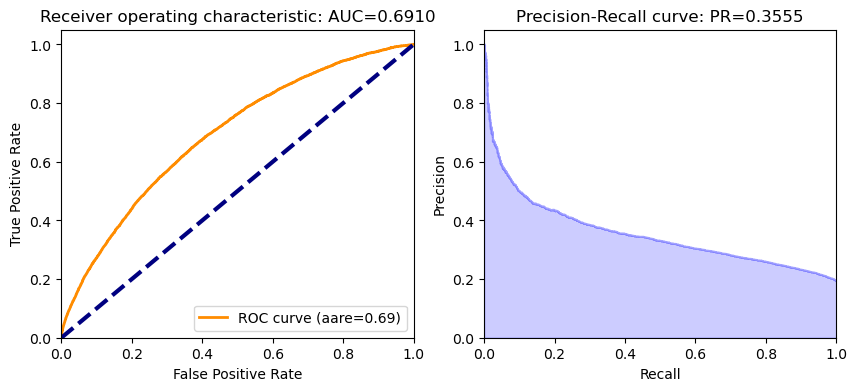

In [36]:
ROC_AUC(best_gbm_model,train_hex,'loan_default')

> ROC AUC Score in Test Data

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

   * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



/Users/jimac/opt/anaconda3/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["AND", "ANDROID", "APPLE", "EYU", "HASEE", "HONGLAJIAO", "IPAD3", "KDDI", "KINGSUN", "MANN", ...1 not listed..., "MLLED", "MONEYMAKINGMACHINE", "OUKI", "PHILIPS", "PROTRULY", "RAMOS", "REDGOO", "SM-W2016", "VOLTE", "YEPEN"]
  warnings.warn(w)


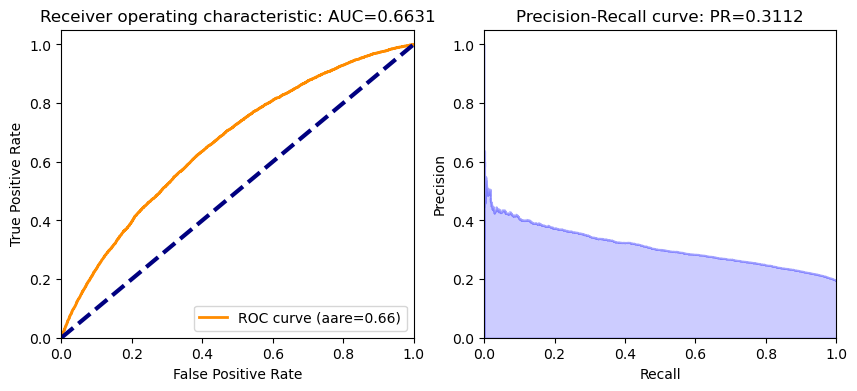

In [37]:
ROC_AUC(best_gbm_model,test_hex,'loan_default')

In [38]:
createGains(best_gbm_model)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/jimac/opt/anaconda3/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["AND", "ANDROID", "APPLE", "EYU", "HASEE", "HONGLAJIAO", "IPAD3", "KDDI", "KINGSUN", "MANN", ...1 not listed..., "MLLED", "MONEYMAKINGMACHINE", "OUKI", "PHILIPS", "PROTRULY", "RAMOS", "REDGOO", "SM-W2016", "VOLTE", "YEPEN"]
  warnings.warn(w)


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1204,1996,3200,1204,1996,0.19,0.08,622.4,1.93,11.0,37.62
1,3200,943,2257,6400,2147,4253,0.34,0.16,1244.8,1.72,18.0,33.55
2,3200,795,2405,9600,2942,6658,0.47,0.26,1867.2,1.58,21.0,30.65
3,3200,707,2493,12800,3649,9151,0.59,0.36,2489.6,1.47,23.0,28.51
4,3200,640,2560,16000,4289,11711,0.69,0.45,3112.0,1.38,24.0,26.81
5,3200,549,2651,19200,4838,14362,0.78,0.56,3734.4,1.30,22.0,25.20
6,3200,453,2747,22400,5291,17109,0.85,0.66,4356.8,1.21,19.0,23.62
7,3200,401,2799,25600,5692,19908,0.91,0.77,4979.2,1.14,14.0,22.23
8,3200,329,2871,28800,6021,22779,0.97,0.88,5601.6,1.07,9.0,20.91


## Section 4: Modeling - Deep Learning <a class="anchor" id="section-4"></a>

In [39]:
target='loan_default'
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

> First, we only take 10% of our data to testing our model, if it's work well, we will continue using this model to train for all the data.

In [40]:
train_smpl = train.sample(frac=0.1, random_state=123)
test_smpl = test.sample(frac=0.1, random_state=123)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [41]:
# Initializing the H2ODeepLearningEstimator
dl_v1 = H2ODeepLearningEstimator(hidden=[128, 64],  # Specify the number of neurons in each hidden layer
                                 epochs=10,         # Number of training epochs
                                 activation='RectifierWithDropout',  # Activation function
                                 seed=1)            # Set a seed for reproducibility

In [42]:
# Train the model with a separate validation frame
dl_v1.train(x=predictors, y=target, training_frame=train_hex, validation_frame=test_hex)

deeplearning Model Build progress: |

/Users/jimac/opt/anaconda3/lib/python3.9/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [TD051, TD062, TD061, CR012, TD029, TD028, TD027, TD026, TD048, TD025, AP005, TD044, TD055]
  warnings.warn(mesg["message"], RuntimeWarning)
/Users/jimac/opt/anaconda3/lib/python3.9/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


█████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_model_python_1700972810962_2


Status of Neuron Layers: predicting loan_default, regression, gaussian distribution, Quadratic loss, 18,945 weights/biases, 234.1 KB, 48,000 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms                momentum    mean_weight             weight_rms           mean_bias            bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  ----------------------  ----------  ----------------------  -------------------  -------------------  -----------------------
    1        82       Input             0.0
    2        128      RectifierDropout  50.0       0.0   0.0   0.07614822458358171    0.24273139238357544     0.0         -0.00207711626463882    0.10143274068832397  0.4813966031604479   0.10422170162200928
    3        64       RectifierDropout  50.0       0.0   0.0   0.009609257443713659   0.012976277619600296    0.0         -0.025309067422691678   0.1047694981098175   0.8056930152975096   0.08197328448295593
    4        1        Linear                       0.0   0.0   0.0004014186317817803  0.00010296973050571978  0.0         -0.0011446039789007045  0.10065755248069763  0.10608332060600312  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.14246091359916024
RMSE: 0.37743994701032935
MAE: 0.2915581606071055
RMSLE: 0.2645915470641381
Mean Residual Deviance: 0.14246091359916024

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.14926076396332472
RMSE: 0.3863428062787305
MAE: 0.29706847511512907
RMSLE: 0.2708332617545177
Mean Residual Deviance: 0.14926076396332472

Scoring History: 
    timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2    validation_rmse    validation_deviance    validation_mae    validation_r2
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------  -----------------  ---------------------  ----------------  ---------------
    2023-11-25 23:33:14  0.000 sec                     0         0             0          nan              nan                  nan             nan            nan                nan                    nan               nan
    2023-11-25 23:33:15  0.798 sec   8955 obs/sec      1         1             4800       0.38518          0.148364             0.276526        0.0335368      0.389909           0.152029               0.279376          0.0243765
    2023-11-25 23:33:16  1.680 sec   36613 obs/sec     10        10            48000      0.37744          0.142461             0.291558        0.0719891      0.386343           0.149261               0.297068          0.0421425

Variable Importances: 
variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
AP003              1.0                    1.0                  0.01837127972482177
TD054.nan          0.8318672776222229     0.8318672776222229   0.015282466451123824
MB005              0.8081935048103333     0.8081935048103333   0.01484754894865472
MB007.WEB          0.7661051750183105     0.7661051750183105   0.01407433246889492
AP006.android      0.7441849112510681     0.7441849112510681   0.013671629171585034
CR015              0.7414310574531555     0.7414310574531555   0.01362103735314232
MB007.LETV         0.7393912076950073     0.7393912076950073   0.013583562702638769
AP006.h5           0.7382434606552124     0.7382434606552124   0.01356247712071736
CR009              0.7381862998008728     0.7381862998008728   0.013561427002672977
MB007.HISENSE      0.7358935475349426     0.7358935475349426   0.013519306209455855


> Predict using leaderboard

In [43]:
pred = dl_v1.predict(test_hex)
pred.head()

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


/Users/jimac/opt/anaconda3/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["4G", "ALPS", "CMDC", "IPHONE3", "QIKU"]
  warnings.warn(w)


predict
0.300067
0.208387
0.223482
0.334812
0.125807
0.151686
0.0995415
0.104234
0.129804
0.194498


In [44]:
perf = dl_v1.model_performance(test_hex)
perf

ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 0.14926076396332472
RMSE: 0.3863428062787305
MAE: 0.29706847511512907
RMSLE: 0.2708332617545177
Mean Residual Deviance: 0.14926076396332472

> ROC AUC Score in Test Data

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

   * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



/Users/jimac/opt/anaconda3/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["4G", "ALPS", "CMDC", "IPHONE3", "QIKU"]
  warnings.warn(w)


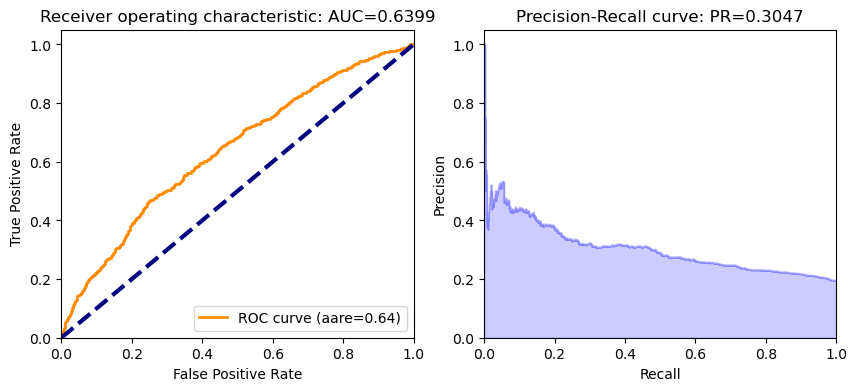

In [45]:
ROC_AUC(dl_v1,test_hex,'loan_default')

In [46]:
createGains(dl_v1)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


/Users/jimac/opt/anaconda3/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["4G", "ALPS", "CMDC", "IPHONE3", "QIKU"]
  warnings.warn(w)


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,122,198,320,122,198,0.20,0.08,61.8,1.97,12.0,38.12
1,320,75,245,640,197,443,0.32,0.17,123.6,1.59,15.0,30.78
2,320,95,225,960,292,668,0.47,0.26,185.4,1.57,21.0,30.42
3,320,54,266,1280,346,934,0.56,0.36,247.2,1.40,20.0,27.03
4,320,59,261,1600,405,1195,0.66,0.46,309.0,1.31,20.0,25.31
5,320,51,269,1920,456,1464,0.74,0.57,370.8,1.23,17.0,23.75
6,320,52,268,2240,508,1732,0.82,0.67,432.6,1.17,15.0,22.68
7,320,48,272,2560,556,2004,0.90,0.78,494.4,1.12,12.0,21.72
8,320,36,284,2880,592,2288,0.96,0.89,556.2,1.06,7.0,20.56


> Entire Dataset

In [47]:
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


> - Find the best Hyperparameter using grid search <a class="anchor" id="section-3-5"></a>

In [48]:
# Define your hyperparameters grid
hyperparameters = {
    'hidden': [[64, 32, 16], [128, 64, 32], [256, 128, 64]],   # Different hidden layer configurations
    'epochs': [5, 10, 15],                                     # Different numbers of epochs
    'activation': ['RectifierWithDropout', 'TanhWithDropout']  # Different activation functions
}

# Define your H2ODeepLearningEstimator
dl = H2ODeepLearningEstimator(seed=1)

# Perform grid search
grid = H2OGridSearch(model=dl, hyper_params=hyperparameters)

# Train the grid search on your data
grid.train(x=predictors, y=target, training_frame=train_hex, validation_frame=test_hex)

# Get the best model from grid search
best_model = grid.get_grid()[0]  # Retrieve the best model
best_model

deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: Grid_DeepLearning_Key_Frame__upload_ae64169ed0d33c4b8c70bbdcb734a4f.hex_model_python_1700972810962_3_model_15


Status of Neuron Layers: predicting loan_default, regression, gaussian distribution, Quadratic loss, 79,873 weights/biases, 953.4 KB, 480,000 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate               rate_rms                momentum    mean_weight             weight_rms           mean_bias            bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ----------------------  ----------------------  ----------  ----------------------  -------------------  -------------------  -----------------------
    1        150      Input             0.0
    2        256      RectifierDropout  50.0       0.0   0.0   0.20077540529890028     0.3542574644088745      0.0         -0.0030188786437818868  0.08470532298088074  0.40841829914127786  0.09675073623657227
    3        128      RectifierDropout  50.0       0.0   0.0   0.01810116980242782     0.011908438056707382    0.0         -0.009566693469187888   0.0866566002368927   0.904533667347059    0.11810562014579773
    4        64       RectifierDropout  50.0       0.0   0.0   0.007836763798128032    0.012212105095386505    0.0         -0.02816902280471334    0.11018204689025879  0.8753494600889123   0.10126924514770508
    5        1        Linear                       0.0   0.0   0.00032611618996725156  0.00013221509288996458  0.0         0.01126112002384616     0.1139136254787445   0.1571230136434633   1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.14595060393771517
RMSE: 0.3820348203210215
MAE: 0.3079666760036122
RMSLE: 0.2708956924159994
Mean Residual Deviance: 0.14595060393771517

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.14871791489513753
RMSE: 0.38563961790139967
MAE: 0.31111229734970924
RMSLE: 0.2731652890290907
Mean Residual Deviance: 0.14871791489513753

Scoring History: 
    timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2    validation_rmse    validation_deviance    validation_mae    validation_r2
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------  -----------------  ---------------------  ----------------  ---------------
    2023-11-25 23:36:36  0.000 sec                           0         0             0          nan              nan                  nan             nan            nan                nan                    nan               nan
    2023-11-25 23:36:38  3 min 16.726 sec  20788 obs/sec     1         1             48000      0.384873         0.148127             0.305042        0.0414258      0.387858           0.150434               0.307582          0.0398016
    2023-11-25 23:36:48  3 min 26.695 sec  25254 obs/sec     6         6             288000     0.382035         0.145951             0.307967        0.0555115      0.38564            0.148718               0.311112          0.0507554
    2023-11-25 23:36:56  3 min 34.332 sec  26422 obs/sec     10        10            480000     0.382187         0.146067             0.306983        0.0547581      0.386143           0.149107               0.310315          0.0482733
    2023-11-25 23:36:57  3 min 35.178 sec  26417 obs/sec     10        10            480000     0.382035         0.145951             0.307967        0.0555115      0.38564            0.148718               0.311112          0.0507554

Variable Importances: 
variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
AP003              1.0                    1.0       

> ROC AUC Score in Test Data

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

   * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



/Users/jimac/opt/anaconda3/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["AND", "ANDROID", "APPLE", "EYU", "HASEE", "HONGLAJIAO", "IPAD3", "KDDI", "KINGSUN", "MANN", ...1 not listed..., "MLLED", "MONEYMAKINGMACHINE", "OUKI", "PHILIPS", "PROTRULY", "RAMOS", "REDGOO", "SM-W2016", "VOLTE", "YEPEN"]
  warnings.warn(w)


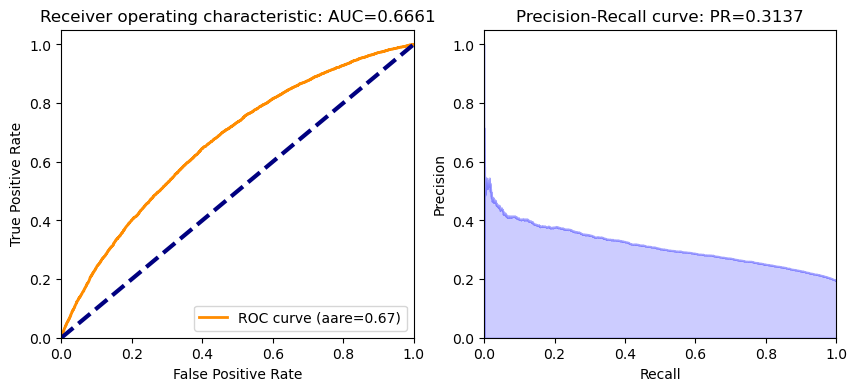

In [49]:
ROC_AUC(best_model,test_hex,'loan_default')

In [50]:
createGains(best_model)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


/Users/jimac/opt/anaconda3/lib/python3.9/site-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'MB007' has levels not trained on: ["AND", "ANDROID", "APPLE", "EYU", "HASEE", "HONGLAJIAO", "IPAD3", "KDDI", "KINGSUN", "MANN", ...1 not listed..., "MLLED", "MONEYMAKINGMACHINE", "OUKI", "PHILIPS", "PROTRULY", "RAMOS", "REDGOO", "SM-W2016", "VOLTE", "YEPEN"]
  warnings.warn(w)


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,3200,1198,2002,3200,1198,2002,0.19,0.08,622.4,1.92,11.0,37.44
1,3200,955,2245,6400,2153,4247,0.35,0.16,1244.8,1.73,19.0,33.64
2,3200,807,2393,9600,2960,6640,0.48,0.26,1867.2,1.59,22.0,30.83
3,3200,726,2474,12800,3686,9114,0.59,0.35,2489.6,1.48,24.0,28.80
4,3200,639,2561,16000,4325,11675,0.69,0.45,3112.0,1.39,24.0,27.03
5,3200,536,2664,19200,4861,14339,0.78,0.56,3734.4,1.30,22.0,25.32
6,3200,468,2732,22400,5329,17071,0.86,0.66,4356.8,1.22,20.0,23.79
7,3200,369,2831,25600,5698,19902,0.92,0.77,4979.2,1.14,15.0,22.26
8,3200,307,2893,28800,6005,22795,0.96,0.88,5601.6,1.07,8.0,20.85


## Section 5: Model Summary & Conclusion <a class="anchor" id="section-5"></a>

### Model `GBM`
- Gradient Boosting Machine (GBM) is an ensemble learning technique that sequentially combines previous decision trees, to create a strong and accurate predictive model. It works by minimizing prediction errors, focusing on areas where previous models performed poorly. In each iteration, GBM builds a new tree that aims to correct the errors made by the existing ensemble. This iterative process continues, with subsequent models learning from the mistakes of their predecessors, resulting in a powerful ensemble model capable of capturing complex patterns in the data.

- In supervised learning tasks for this homework in mortgage probability of default prediction, GBM can be utilized for anomaly detection by training on historical mortgage data to predict the likelihood of default. Subsequently, the model's predictions on new data can highlight instances where the predicted default probabilities significantly diverge from expected norms. Such deviations could signify potential anomalies or outliers warranting further investigation, enabling proactive risk assessment and management strategies for these atypical cases within our mortgage dataset.

> Model: gbm_v1
- Dataset used: 10% of entire data
- Hyperparameters: Default setting
- ROC AUC Score: `0.613`
- Precision-Recall: `0.2661`
- In decile 0 subset: Lift: `1.73`, Gains: `33.44`

> Model: gbm_v2
- Dataset used: Entire data
- Hyperparameters: ntrees = `500`, nfolds = `10`, min_rows = `100`,
- ROC AUC Score: `0.6555`
- Precision-Recall: `0.3025`
- In decile 0 subset: Lift: `1.84`, Gains: `35.88`

> Model: gbm_v3 **(Best)**
- Dataset used: Entire data, but selected Scaled Importance greater than 5% in gbm_v2 model , only use top 30 importance variables to build our model
- Grid search range: `learn_rate`: [0.05, 0.1, 0.2], `max_depth`: [3, 4, 5], `sample_rate`: [0.8, 0.9, 1.0]
- Final Set of Hyperparameters: learn_rate = `0.2`, max_depth = `3`, sample_rate = `0.9`
- ROC AUC Score: `0.6631`
- Precision-Recall: `0.3112`
- In decile 0 subset: Lift: `1.93`, Gains: `37.62`

### Model `Deep Learning`
- Deep Learning operates through intricate neural networks composed of multiple layers, allowing it to autonomously extract complex patterns and representations from data. By leveraging deep architectures and nonlinear activation functions, Deep Learning models like neural networks can discern intricate relationships, making them adept at capturing dependencies within datasets. The iterative backpropagation process, which adjusts network weights based on prediction errors, enables these models to learn nuanced features from the data automatically.

- In this mortgage probability of default dataset, Deep Learning can be employed to detect anomalies by training on historical mortgage data and predicting the probability of default. The trained model's predictions on new data can uncover instances where the predicted default probabilities deviate notably from expected patterns. Such deviations might signal anomalies or outliers within the dataset, prompting further investigation in risk mitigation strategies.

> Model: `dl_v1`
- Dataset used: 10% of entire data
- Hyperparameters: hidden= `[128, 64]`, epochs = `10`, activation = `RectifierWithDropout`
- ROC AUC Score: `0.6409`
- Precision-Recall: `0.3021`
- In decile 0 subset: Lift: `1.8`, Gains: `34.69`

> Model: `dl_v2` **(Best)**
- Dataset used: Entire data
- Grid search range: `hidden`: [64, 32, 16], [128, 64, 32], [256, 128, 64], `epochs`: [5, 10, 15], `activation`: [RectifierWithDropout, TanhWithDropout]
- Final Set of Hyperparameters: hidden = `[128, 64, 32]`, epochs = `15`, activation = `RectifierWithDropout`
- ROC AUC Score: `0.6639`
- Precision-Recall: `0.3128`
- In decile 0 subset: Lift: `1.91`, Gains: `37.16`

For GBM, the iterative approach showed significant improvements across versions. The gbm_v3 model emerged as the best performer. It utilized the entire dataset, leveraging top 30 scaled importance variables from gbm_v2. The final hyperparameters, specifically tuned through grid search, were: `learn_rate = 0.2`, `max_depth = 3`, and `sample_rate = 0.9`. This model achieved an ROC AUC Score of `0.6631` and a Precision-Recall of `0.3112`, showcasing a Lift of `1.93` and Gains of `37.62` in the decile 0 subset.

On the other hand, the DL models showcased significant improvement from dl_v1 to dl_v2, with dl_v2 being the top performer. Trained on the entire dataset, it utilized a `hidden layer` configuration of `[128, 64, 32]`, `epochs = 15`, and employed the `RectifierWithDropout` activation function. This DL model achieved an ROC AUC Score of `0.6639`, a Precision-Recall of `0.3128`, and demonstrated a Lift of `1.91` and Gains of `37.16` in the decile 0 subset.

The best-performing GBM and DL models showcased competitive performance, but ultimately, the DL model `dl_v2` with hyperparameters `[128, 64, 32]` hidden layers, `epochs = 15`, and `RectifierWithDropout` activation function delivered the superior outcome based on the specified evaluation criteria of ROC and cumulative Lift. These models are good to detect anomalies and predict mortgage probability of default effectively within this dataset.